In [10]:
import sys
import os
sys.path.append('/home/alina/repos/Audio-Classification-HF/')

import numpy as np
import torch

from datasets import DatasetDict, load_dataset, load_metric, concatenate_datasets
from transformers import (
    AutoConfig,
    set_seed,
    Wav2Vec2Processor,
    WavLMForSequenceClassification,
    AutoFeatureExtractor
)

from dataclasses import dataclass
from typing import Dict, List, Any, Optional, Union, Tuple

In [2]:
@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [4]:
PROJECT_ROOT = "/home/alina/repos/Audio-Classification-HF"
set_seed(42)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
INPUT_FIELD = "input_values"
LABEL_FIELD = "labels"

def prepare_dataset(examples, feature_extractor):
    audio_arrays = [x["array"] for x in examples["audio"]]
    input = feature_extractor(
        audio_arrays, 
        sampling_rate=16000, 
        padding=True, 
        return_tensors="pt"
    )

    examples[INPUT_FIELD] = input.input_values.to(device)
    examples[LABEL_FIELD] = examples[ "emotion"]  # colname MUST be labels as Trainer will look for it by default

    return examples



In [24]:
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/wavlm-large")
model_path = "./models/wavlm_01_exp/audio-model"

config = AutoConfig.from_pretrained(
        model_path,
    )

model = WavLMForSequenceClassification.from_pretrained(
        model_path,
        config=config,
        trust_remote_code=True,
    ).to(device)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


In [25]:
dataset = load_dataset("xbgoose/dusha")

ds_ang = dataset['train'].filter(lambda example: example["emotion"] == "angry")
ds_hap = dataset['train'].filter(lambda example: example["emotion"] == "positive")
ds_sad = dataset['train'].filter(lambda example: example["emotion"] == "sad")
ds_neu = dataset['train'].filter(lambda example: example["emotion"] == "neutral")
ds_oth = dataset['train'].filter(lambda example: example["emotion"] == "other")

ds_a = ds_ang.shard(num_shards=4, index=0)
ds_h = ds_hap.shard(num_shards=4, index=0)
ds_s = ds_sad.shard(num_shards=6, index=0)
ds_n = ds_neu.shard(num_shards=30, index=0)
ds_o = ds_oth

ds = concatenate_datasets([ds_a, ds_h, ds_s, ds_n, ds_o])

train_testvalid = ds.train_test_split(shuffle=True, test_size=0.1, seed=42)
test_valid = train_testvalid["test"].train_test_split(test_size=0.5, seed=42)


In [26]:
ds = DatasetDict(
    {
        "train": train_testvalid["train"],
        "test": test_valid["test"],
        "val": test_valid["train"],
    }
)

In [27]:
ds = ds.class_encode_column("emotion")

In [28]:
ds['test'].features['emotion'].names

['angry', 'neutral', 'other', 'positive', 'sad']

In [29]:
encoded_dataset = ds.map(prepare_dataset, 
                              fn_kwargs={"feature_extractor": feature_extractor}, 
                              remove_columns=["audio"],
                              batched=True, 
                              batch_size=4)

In [30]:
from tqdm import tqdm

model.eval()
preds = []
for sample in tqdm(encoded_dataset['test']):
    logits = model(torch.cuda.FloatTensor(sample['input_values']).unsqueeze(dim=0)).logits
    # print(logits)
    predictions = torch.argmax(logits, dim=-1)
    # print(predictions)  
    predicted_emotion = config.id2label[predictions.cpu().data.numpy()[0]]
    preds.append(predicted_emotion)
    # print(predicted_emotion)

100%|██████████| 788/788 [01:13<00:00, 10.79it/s]


In [31]:
gts  = [config.id2label[gt] for gt in encoded_dataset['test']['labels']]

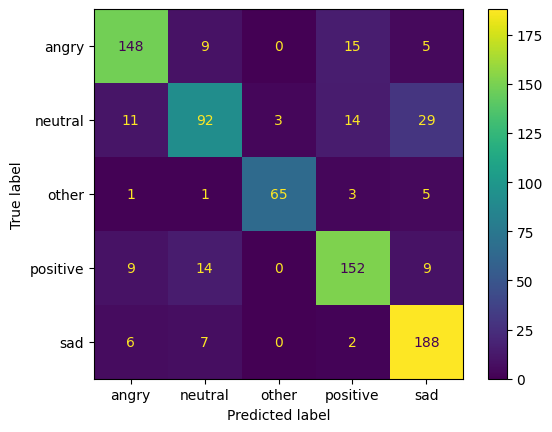

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(gts, preds, labels=list(config.label2id.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(config.label2id.keys()))
disp.plot()

plt.show()

In [34]:
from sklearn.metrics import classification_report

print(classification_report(gts, preds, target_names=list(config.label2id.keys())))

              precision    recall  f1-score   support

       angry       0.85      0.84      0.84       177
     neutral       0.75      0.62      0.68       149
       other       0.96      0.87      0.91        75
    positive       0.82      0.83      0.82       184
         sad       0.80      0.93      0.86       203

    accuracy                           0.82       788
   macro avg       0.83      0.81      0.82       788
weighted avg       0.82      0.82      0.82       788



: 